In [292]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
from datetime import datetime
from ta import add_all_ta_features

# Data extraction & Returns Overview

In [293]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol , start_date , end_date)
df = strat_mgr.df.copy()

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2023-10-09,27934.472656,27989.470703,27302.562500,27583.677734,12007668568,-0.012580,0.025159,3.185758
2023-10-10,27589.201172,27715.847656,27301.654297,27391.019531,9973350678,-0.006985,0.015171,3.156683
2023-10-11,27392.076172,27474.115234,26561.099609,26873.320312,13648094333,-0.018900,0.034374,3.078116
2023-10-12,26873.292969,26921.439453,26558.320312,26756.798828,9392909295,-0.004336,0.013673,3.059839
2023-10-13,26752.878906,27092.697266,26686.322266,26862.375000,15165312851,0.003946,0.015228,3.076439


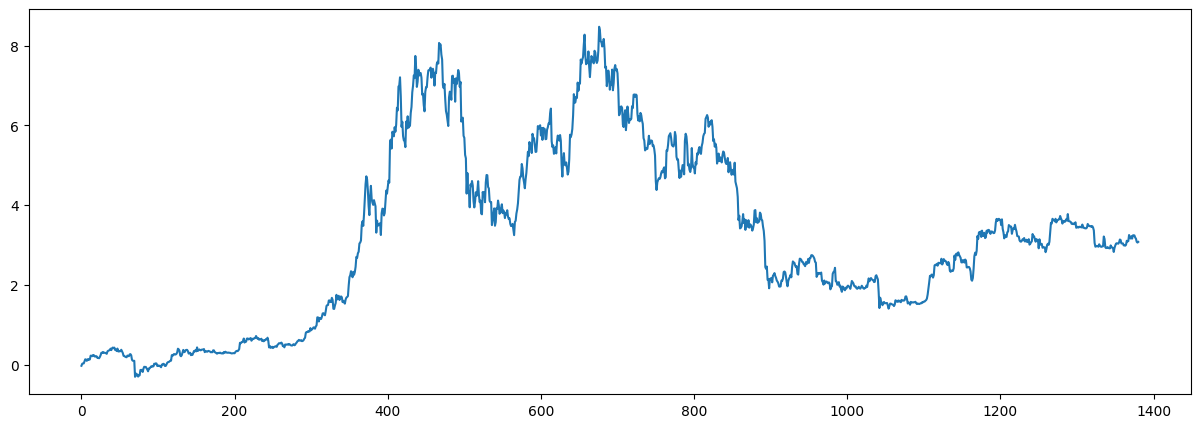

In [294]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

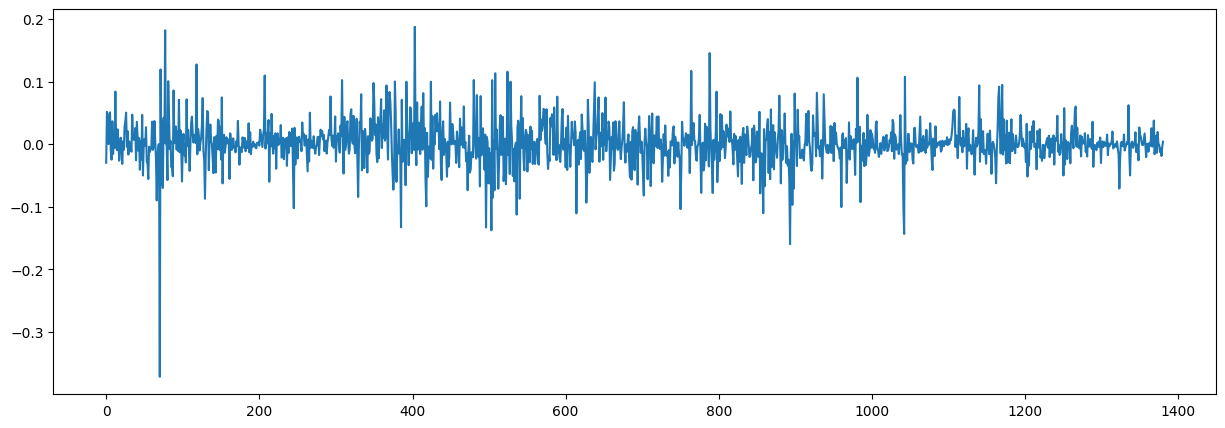

In [295]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Returns"].values)
plt.show()

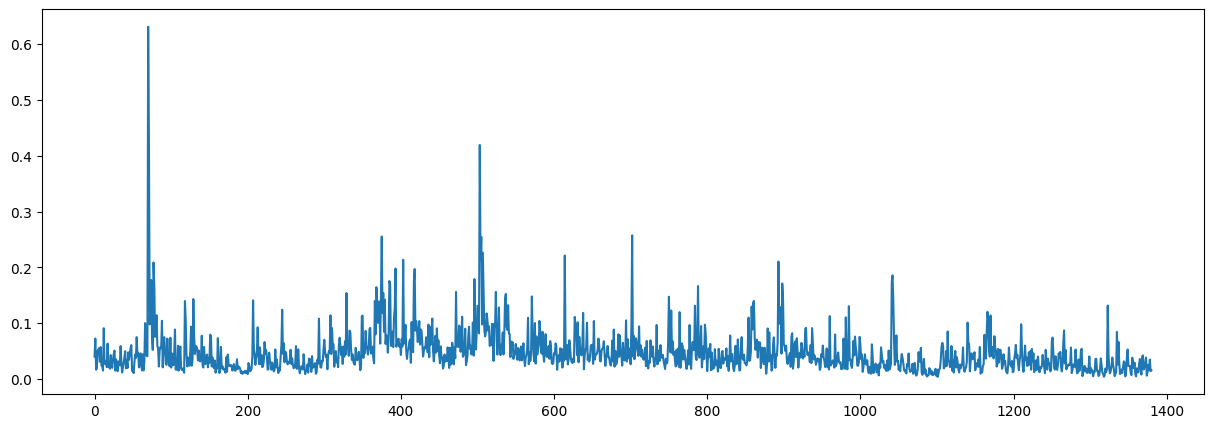

In [296]:
fig = plt.figure(figsize=(15,5))
plt.plot(df["Range"].values)
plt.show()

# Feature Engineering - Feature Expantion

In [297]:
df_fe = df.copy()

# Indicators

In [298]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi

df_fe["RSI_Return"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [299]:
# Add moving averages
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [300]:
# Day of the week
df_fe["DOW"] = df_fe.index.dayofweek

In [301]:
# Rolling Cumalitive returns
df_fe["Rolling_rets"] = df_fe["Returns"].rolling(window=30).sum()

In [302]:
# Rolling Cumalitive Range
df_fe["AVG_Range"] = df_fe["Range"].rolling(window=30).mean()

In [303]:
# Technical Analysis Features 
# df_fe = add_all_ta_features( 
#     df_fe , open="Open", high="High", low="Low", close="Close", volume="Volume" , fillna=True
#  )

## Time Intervals

In [304]:
# Add Time Intervals
time_steps = [1,2]
time_features = ["Returns", "Range", "Rolling_rets"]
for ts in time_steps:
    for tf in time_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

### Feature Engineering

In [305]:
# Correct for stationarity
df_stationary = df_fe.copy()

df_stationary[["Open","High","Low","Volume"]] = df_stationary[["Open","High","Low","Volume"]].pct_change()

# ASSES DATA FOR ML READINESS

In [306]:
# Check for NaN
df_stationary = df_stationary.dropna()

In [307]:
# Check for inf values
dfobj = df_stationary.isin([np.inf,-np.inf])
count = np.isinf(dfobj).values.sum()

In [308]:
# Check for non numerical objects
df_stationary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1350 entries, 2020-02-02 to 2023-10-13
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1350 non-null   float64
 1   High             1350 non-null   float64
 2   Low              1350 non-null   float64
 3   Close            1350 non-null   float64
 4   Volume           1350 non-null   float64
 5   Returns          1350 non-null   float64
 6   Range            1350 non-null   float64
 7   Bench_C_Rets     1350 non-null   float64
 8   RSI              1350 non-null   float64
 9   RSI_Return       1350 non-null   float64
 10  MA_12            1350 non-null   float64
 11  MA_21            1350 non-null   float64
 12  DOW              1350 non-null   int64  
 13  Rolling_rets     1350 non-null   float64
 14  AVG_Range        1350 non-null   float64
 15  Returns_T1       1350 non-null   float64
 16  Range_T1         1350 non-null   float64
 

In [309]:
# describe dataframe
df_stationary.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,MA_21,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,...,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,0.001424,0.001252,0.001470,28857.555046,0.041610,0.001422,0.047029,3.241975,52.108880,1.004946,...,28721.516827,2.998519,0.045126,0.047145,0.001423,0.047028,0.045335,0.001414,0.047041,0.045510
std,0.035507,0.030679,0.036467,15212.339137,0.330862,0.035449,0.040586,2.190842,13.785187,0.104528,...,15143.773968,2.000741,0.204436,0.020814,0.035449,0.040587,0.204561,0.035452,0.040579,0.204655
min,-0.365924,-0.263712,-0.364062,4970.788086,-0.869188,-0.371695,0.003596,-0.305805,14.037826,0.456113,...,5984.235073,0.000000,-0.613606,0.015756,-0.371695,0.003596,-0.613606,-0.371695,0.003596,-0.613606
25%,-0.013583,-0.011757,-0.011121,17089.914062,-0.145936,-0.013792,0.023081,1.570138,42.553880,0.952544,...,17016.254046,1.000000,-0.085018,0.032841,-0.013792,0.023081,-0.085018,-0.013800,0.023089,-0.085018
50%,0.000315,-0.000588,0.002462,26921.179688,-0.005708,0.000234,0.037966,3.087917,50.634345,1.000598,...,26956.641648,3.000000,0.023483,0.044364,0.000234,0.037966,0.023483,0.000234,0.037966,0.023483
75%,0.016527,0.013231,0.014935,39745.708008,0.171083,0.016529,0.057513,4.953430,60.911846,1.047763,...,40250.692197,5.000000,0.187727,0.055086,0.016529,0.057513,0.188485,0.016529,0.057513,0.190285
max,0.187677,0.187159,0.247892,67566.828125,5.439003,0.187465,0.631387,8.471219,90.719434,1.915829,...,63016.876488,6.000000,0.818827,0.118472,0.187465,0.631387,0.818827,0.187465,0.631387,0.818827


## SAVE DATAFRAME

In [310]:
# use or create folder to save data
import os

folder_name = 'data'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"'{folder_name}' has been created")
else:
    print(f"'{folder_name}' already exists")

'data' already exists


In [311]:
# Save ASSET Symbol
with open(f"{folder_name}/saved_symbol.txt", "w") as f:
    f.write(symbol)

In [312]:
# save dataframe into csv
df_stationary.to_csv(f"{folder_name}/{symbol}.csv")